In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import theano.tensor as tt
#import matplotlib.pyplot as plt
import theano.tensor.slinalg as sla
from pymc3.distributions.transforms import t_stick_breaking
from pymc3 import math as pmmath
import seaborn as sns
from scipy.misc import logsumexp 


***Use generative process to create toy data***

In [2]:
# 
L = 5
N = 10
num_clusters = 3
num_values = 3

pi = pm.Dirichlet.dist(a=np.ones(num_clusters),shape=(num_clusters)).random()

theta_i = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_clusters,num_values)).random()

theta_t = pm.Dirichlet.dist(a=pm.floatX((1.0 / num_values) * np.ones((num_values))),
                     shape=(num_clusters,num_values,num_values)).random()


In [3]:
data = []
clusters = []
for d in range(N):
    # draw a cluster
    #cluster = np.random.choice(num_cluster,p=pi)
    cluster = pm.Categorical.dist(pi).random(size=1)[0]
    values = []
    # draw initial value 
    #prev_value = np.random.choice(num_cluster,p=theta_i[cluster])
    prev_value = pm.Categorical.dist(theta_i[cluster]).random(size=1)[0]
    values.append(prev_value)
    for l in range(L-1):
        # draw next value based on previous value
        #next_value = np.random.choice(num_cluster,p=theta_t[cluster,prev_value])
        next_value = pm.Categorical.dist(theta_t[cluster,prev_value]).random(size=1)[0]
        values.append(prev_value)
        prev_value = next_value
    data.append(values)
    clusters.append(cluster)

In [5]:
# convert to matrix
data = np.matrix(data)
data

matrix([[0, 0, 2, 2, 2],
        [0, 0, 0, 0, 2],
        [0, 0, 2, 2, 2],
        [1, 1, 0, 0, 0],
        [1, 1, 2, 2, 2],
        [0, 0, 2, 2, 2],
        [0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 2, 2, 2],
        [1, 1, 2, 2, 2]])

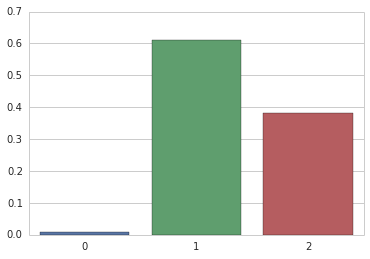

In [6]:
# plot cluster probabilities
sns.set(style="whitegrid")
sns.barplot(x=range(3),y=pi)

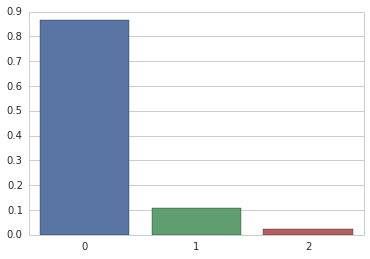

In [7]:
# initial probabilities for cluser 0
sns.barplot(x=range(num_values),y=theta_i[0])

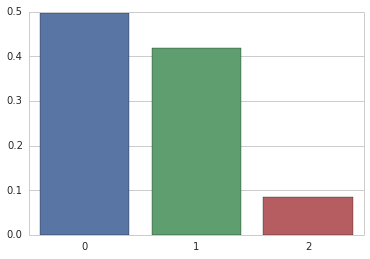

In [8]:
# initial probabilities for cluster 1
sns.barplot(x=range(num_values),y=theta_i[1])

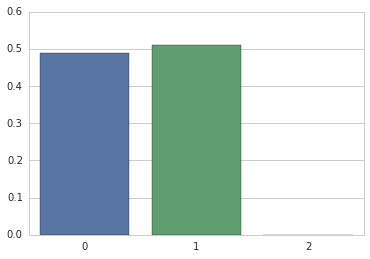

In [9]:
# initial probabilities for cluser 2
sns.barplot(x=range(num_values),y=theta_i[2])

In [10]:
# print assignments
clusters

[2, 1, 2, 1, 2, 2, 1, 1, 2, 2]

***Several tests to compare the log likelihood using regular python, numpy and theano****

In [15]:
# to compare computations wiht theano, transform data
data = data.astype("int32")
theta_i = theta_i.astype("float32")
theta_t = theta_t.astype("float32")
pi = pi.astype("float32")


# dirty way to compute likelihood of full data
l_data = []
for didx in range(len(data)):
    l_obs = []
    for pidx in range(3):
        trans = []
        for iidx in range(data[didx].shape[1]-1):
            trans.append(np.log(theta_t[pidx][data[didx,iidx],data[didx,iidx+1]]))
        l_obs.append(np.log(pi[pidx]) + np.log(theta_i[pidx][data[didx,0]]) + np.sum(trans))
    
    l_data.append(logsumexp(l_obs))
np.sum(l_data)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.


-39.673965

In [22]:
# same using numpy
t1 = np.log(pi)*np.ones((10,1))
t2 = np.column_stack(np.log(theta_i[:,data[:,0]]))
t3 = np.sum(np.log(theta_t[:,data[:,:-1],data[:,1:]]),axis=2).T
l_obs  = logsumexp(t1+t2+t3,axis=1)
np.sum(l_obs)

/Users/bieljoanisaac/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  """


-39.67396787240941

In [23]:
### Same computations with theano
import theano
import theano.tensor as tt
import theano
theano.config.compute_test_value = "ignore"
theano.config.on_unused_input='ignore'

data = np.matrix(data)
tdata = tt.imatrix('tdata')
ttheta_i = tt.fmatrix('ttheta_i')
ttheta_t = tt.tensor3('ttheta_t')
tpi = tt.fvector('tpi')

# compute the full likelihood of data with theano
out = tt.sum(pmmath.logsumexp(tt.log(tpi)*tt.ones((10,1))+\
                              tt.log(ttheta_i[:,tdata[:,0]]).T+\
                              tt.sum(tt.log(ttheta_t[:,tdata[:,:-1],tdata[:,1:]]),axis=2).T
                              ,axis=1))
f = theano.function([tpi,ttheta_i,ttheta_t,tdata], out)
f(pi,theta_i,theta_t,data)

array(-39.67396767)

***Build bayesian model using pymc3***

In [ ]:
#### log likelihood
def log_data(pi,theta_init,theta_trans):
    def log_data_(docs):
        t1 = tt.log(pi)*tt.ones((10,1))
        t2 = tt.log(theta_init[:,docs[:,0]]).T
        t3 = tt.sum(theta_trans[:,docs[:,:-1],docs[:,1:]],axis=2).T
        return tt.sum(pmmath.logsumexp(t1+t2+t3,axis=1))
    
    return log_data_

***Note***: the folowing throws an error 

In [ ]:

with pm.Model() as model:   
    # the posterior distribution of a multinomial with a dirichlet prior is another dirichlet prior
    pi = pm.Dirichlet('pi', a=pm.floatX((1.0 / num_clusters) * np.ones(num_clusters)),
                      shape=(num_clusters),transform=t_stick_breaking(1e-9))
    theta_i = pm.Dirichlet('theta_i', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters,num_values))),
                     shape=(num_clusters, num_values), transform=t_stick_breaking(1e-9))
   
    theta_t =  pm.Dirichlet('theta_t', a=pm.floatX((1.0 / num_values) * np.ones((num_clusters,num_values, num_values))),
                     shape=(num_clusters,num_values, num_values), transform=t_stick_breaking(1e-9))
    # how do we aggregate the likelihood of all the data
    obs = pm.DensityDist('obs', log_data(pi, theta_i, theta_t), observed=data)
    
    #start = pm.find_MAP(fmin=optimize.fmin_powell)
    ##step1 = pm.Metropolis(vars=[P,A,S,PA,emission])
    #step2 = pm.CategoricalGibbsMetropolis(vars=[states])
    #trace = pm.sample(10000, start=start, step=[step1,step2],njobs=1)

In [ ]:
# theanos requires to have squared data
# https://github.com/keras-team/keras/issues/40
# import keras
# preproc_seqs = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_len_seq,padding='post')

# another way to variable lengths?
# https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html
    